# Segment trees

## Detour: Range minimum query

Problem: given an array $A$, quickly find the minimum element between two given indices $i$ and $j$.

> Note: all intervals here are half-open (i.e. $i$ to $j$ means $A[i, j)$ or `A[i:j]`).


### 1. Easy solution

In [1]:
A = [2, 4, 3, 1, 6, 7, 8, 9, 1, 7]

def argmin(A, i, j):
  if i >= j: return -1
  return min(range(i, min(len(A), j)), key=lambda x: A[x])

In [18]:
# <O(1), O(n)>

def preprocess(A):
  return A
def query(A, i, j):
  return argmin(A, i, j)

query(A, 2, 7), query(A, 4, 9)

(3, 8)

### 2. Dynamic programming solution

In [19]:
# <O(n^3), O(1)>
# Pre-compute

def preprocess(A):
  # Store RMQ(A, i, j) in a table
  T = {}
  for i in range(len(A)):
    for j in range(i + 1, len(A)):
      T[i, j] = argmin(A, i, j)
  return T

def query(T, i, j):
    return T[i,j]

T = preprocess(A)
query(T, 2, 7), query(T, 4, 9)

(3, 8)

In [8]:
# <O(n^2), O(1)>
# Dynamic programming

def preprocess(A):
  # Store RMQ(A, i, j) in a table
  T = {(i, i): i for i in range(len(A))}
  for i in range(len(A)):
    for j in range(i + 1, len(A)):
      T[i, j] = T[i, j - 1] if A[T[i, j - 1]] < A[j] else j
  return T

def query(T, i, j):
    return T[i, j]

T = preprocess(A)
query(T, 2, 7), query(T, 4, 9)

(3, 8)

### 3. Smarter dynamic programming solutions via table ranges

In [29]:
# <O(n), O(sqrt(n))>
# Split table

import math

sz = int(math.sqrt(len(A)))
def preprocess(A):
  return [argmin(A, i, i + sz) for i in range(0, len(A), sz)]

def query(A, M, i, j):
  p1, p2 = i // sz, j // sz
  il = argmin(A, i, p1 * sz + sz)
  im = min(M[p1 + 1:p2])
  ir = argmin(A, p2 * sz, j)
  if il >= 0 and A[il] <= min(A[im], A[ir]): 
    return il
  if im >= 0 and A[im] <= min(A[il], A[ir]): 
    return im
  return ir

M = preprocess(A)
query(A, M, 2, 7), query(A, M, 4, 9)

(3, 8)

In [34]:
# <O(n log(n)), O(1)>
# Sparse tables

import math

def preprocess(A):
  T = {(i, 0): i for i in range(len(A))}
  j = 1
  while 2 ** j < len(A):
    i = 0
    while i + 2 ** j - 1 < len(A):
      if A[T[i, j - 1]] < A[T[i + 2 ** (j - 1), j - 1]]:
        T[i, j] = T[i, j - 1] 
      else:
        T[i, j] = T[i + 2 ** (j - 1), j - 1]
      i += 1
    j += 1
  return T

def query(M, i, j):
  k = int(math.log(j - i + 1))
  if A[T[i, k]] < A[T[j - 2 ** k + 1, k]]:
    return M[i, k]
  else:
    return M[j - 2 ** k + 1, k]

T = preprocess(A)
query(T, 2, 7), query(T, 4, 9)

(3, 8)

## Segment trees

If we push the table ranges idea further, we reach segment trees!

### 4. Segment trees

In [15]:
# <O(n), O(log(n))>
# Segment trees for RMQ

def preprocess(A, tree, node=0, st=0, ed=len(A)):
  if st + 1 >= ed:
    tree[node] = st
  else:
    l = preprocess(A, tree, 2 * node + 1, st, (st + ed) // 2)
    r = preprocess(A, tree, 2 * node + 2, (st + ed) // 2, ed)
    tree[node] = l if A[l] <= A[r] else r
  return tree[node]

def query(A, tree, i, j, node=0, st=0, ed=len(A)):
  if i >= ed or j <= st:
    return -1
  if st >= i and ed <= j:
    return tree[node]
  l = query(A, tree, i, j, 2 * node + 1, st, (st + ed) // 2)
  r = query(A, tree, i, j, 2 * node + 2, (st + ed) // 2, ed)

  if l == -1: return r
  if r == -1: return l
  return l if A[l] <= A[r] else r

tree = {}
preprocess(A, tree)
query(A, tree, 2, 7), query(A, tree, 4, 9)

(3, 8)

Segment trees can be used for many other range queries. Let's try using them to answer
the following queries: give me the sum of all elements between $i$ and $j$.

In [2]:
# <O(n), O(log(n))>
# Segment trees for range sum

def preprocess(A, tree, node=0, st=0, ed=len(A)):
  assert st < ed
  if st + 1 == ed:
    tree[node] = A[st]
  else:
    l = preprocess(A, tree, 2 * node + 1, st, (st + ed) // 2)
    r = preprocess(A, tree, 2 * node + 2, (st + ed) // 2, ed)
    tree[node] = l + r
  return tree[node]

def query(tree, i, j, node=0, st=0, ed=len(A)):
  if i >= ed or j <= st:
    return -1
  if st >= i and ed <= j:
    return tree[node]
  l = query(tree, i, j, 2 * node + 1, st, (st + ed) // 2)
  r = query(tree, i, j, 2 * node + 2, (st + ed) // 2, ed)

  if l == -1: return r
  if r == -1: return l
  return l + r

tree = {}
preprocess(A, tree)
query(tree, 2, 7), query(tree, 4, 9)

(25, 31)

Let us plot the tree. Nodes are labeled with their segment (interval) and the value interval holds.

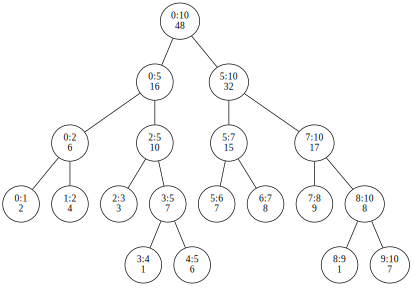

In [3]:
import graphviz

def plot(tree):
  def preprocess(g, tree, node=0, st=0, ed=len(A)):
    assert st < ed
    if st + 1 == ed:
      g.node(str(node), label=f'{st}:{st+1}\n{tree[node]}')
    else:
      preprocess(g, tree, 2 * node + 1, st, (st + ed) // 2)
      preprocess(g, tree, 2 * node + 2, (st + ed) // 2, ed)
      g.node(str(node), label=f'{st}:{ed}\n{tree[node]}')
  g = graphviz.Graph()
  g.graph_attr.update(size="6,4")
  preprocess(g, tree)
  for n in tree:
    if 2*n+1 in tree: g.edge(str(n), str(2*n+1))
    if 2*n+2 in tree: g.edge(str(n), str(2*n+2))
  return g

plot(tree)

Segment trees allow us to support efficient table update requests as well:

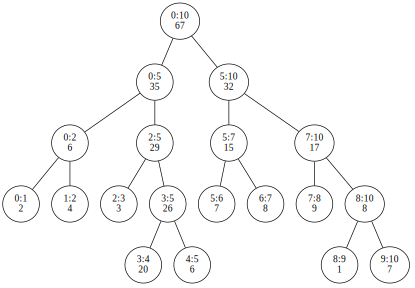

In [4]:
# O(log(n)) update procedure; O(span * log(n)) range update

def update(tree, i, val, node=0, st=0, ed=len(A)):
  if st + 1 == ed:
    if st == i: 
      tree[node] = val
  else:
    l = update(tree, i, val, 2 * node + 1, st, (st + ed) // 2)
    r = update(tree, i, val, 2 * node + 2, (st + ed) // 2, ed)
    tree[node] = l + r
  return tree[node]

def range_update(tree, i, j, val):
  for x in range(i, j):
    update(tree, x, val)

update(tree, 3, 20)
plot(tree)


Naive update is not very performant if we want to update the whole range in batch.
For that sort of queries, we can use **lazy propagation**.

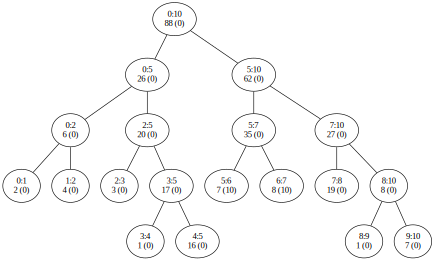

In [15]:
# O(log(n)) range update

class Node:
  def __init__(self, val):
    self.value = val
    self.lazy = 0
  def __str__(self):
    return f'{self.value} ({self.lazy})'


def preprocess(A, tree, node=0, st=0, ed=len(A)):
  assert st < ed
  if st + 1 == ed:
    tree[node] = Node(A[st])
  else:
    l = preprocess(A, tree, 2 * node + 1,     st,             (st + ed) // 2)
    r = preprocess(A, tree, 2 * node + 2, (st + ed) // 2, ed)
    tree[node] = Node(l.value + r.value)
  return tree[node]


def update(tree, i, j, val, node=0, st=0, ed=len(A)):
  if tree[node].lazy != 0: # lazy node, update it
    tree[node].value += (ed - st) * tree[node].lazy
    if st + 1 < ed:
      tree[node * 2 + 1].lazy += tree[node].lazy
      tree[node * 2 + 2].lazy += tree[node].lazy
    tree[node].lazy = 0 # not lazy anymore
  if i >= ed or j <= st:
    pass
  elif st >= i and ed <= j:
    tree[node].value += (ed - st) * val
    if st + 1 < ed:
      tree[node * 2 + 1].lazy += val
      tree[node * 2 + 2].lazy += val
  else:
    update(tree, i, j, val, 2 * node + 1, st, (st + ed) // 2)
    update(tree, i, j, val, 2 * node + 2, (st + ed) // 2, ed)
    tree[node].value = tree[2 * node + 1].value + tree[2 * node + 2].value


def query(tree, i, j, node=0, st=0, ed=len(A)):
  if tree[node].lazy != 0: # lazy node, update it
    tree[node].value += (ed - st) * tree[node].lazy
    if st + 1 < ed:
      tree[node * 2 + 1].lazy += tree[node].lazy
      tree[node * 2 + 2].lazy += tree[node].lazy
    tree[node].lazy = 0 # not lazy anymore
  if i >= ed or j <= st:
    return 0
  elif st >= i and ed <= j:
    return tree[node].value
  else:
    l = query(tree, i, j, 2 * node + 1, st, (st + ed) // 2)
    r = query(tree, i, j, 2 * node + 2, (st + ed) // 2, ed)
    return l + r


tree = {}
preprocess(A, tree)
update(tree, 4, 8, 10)
plot(tree)

55 71


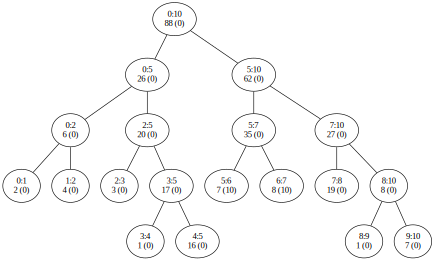

In [16]:
print(query(tree, 2, 7), query(tree, 4, 9)) # 25 + 30, 31 + 40
plot(tree)

## Dynamic segment trees

Instead of using an array, we can also use the standard binary search tree data structure
to implement segment trees. If the tree is sparse, this solution is more efficient.
And it's easier to code and debug.

25 31


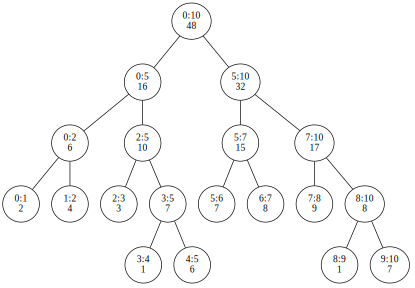

In [32]:
class Node:
  def __init__(self, val, st, ed):
    self.left = None
    self.right = None
    self.value = val
    self.st, self.ed = st, ed


def plot(node):
  def preprocess(g, node, parent=None):
    id = f'{node.st}_{node.ed}'
    g.node(id, label=f'{id.replace("_", ":")}\n{node.value}')
    if parent: g.edge(parent, id)
    if node.left: preprocess(g, node.left, id)
    if node.right: preprocess(g, node.right, id)
  g = graphviz.Graph()
  g.graph_attr.update(size="6,4")
  preprocess(g, node)
  return g


def insert(node, i, val):
  if node.st + 1 == node.ed and node.st == i:
    diff = val - node.value
    node.value = val
    return diff
  mid = (node.st + node.ed) // 2
  if i < mid:
    if node.left is None:
      node.left = Node(0, node.st, mid)
    val = insert(node.left, i, val)
    node.value += val
  else:
    if node.right is None:
      node.right = Node(0, mid, node.ed)
    val = insert(node.right, i, val)
    node.value += val
  return val


def query(node, i, j):
  if node.st >= i and node.ed <= j:
    return node.value
  s = 0
  if node.left: s += query(node.left, i, j)
  if node.right: s += query(node.right, i, j)
  return s


n = Node(0, st=0, ed=len(A))
for ai, a in enumerate(A):
  insert(n, ai, a)
print(query(n, 2, 7), query(n, 4, 9))
plot(n)

## Resources

http://www.topcoder.com/thrive/articles/Range%20Minimum%20Query%20and%20Lowest%20Common%20Ancestor
http://www.topcoder.com/thrive/articles/Binary%20Indexed%20Trees 
https://stackoverflow.com/questions/17466218/what-are-the-differences-between-segment-trees-interval-trees-binary-indexed-t
